# Andrew Yang's Freedom Dividend: Revenue-neutral amount

Estimate the effect of Andrew Yang's [Freedom Dividend](https://www.yang2020.com/policies/the-freedom-dividend/) of $12,000 per year per adult citizen age 18 or older, funded by a 10 percent [value-added tax](https://www.yang2020.com/policies/value-added-tax/) and reducing benefits by up to the UBI amount for each tax unit.

Assumptions:
* Adults are 18+ not 19+, for data availability.
* Benefits include SNAP, WIC, SSI, TANF, WIC, Social Security, and unemployment insurance. Per Yang's [tweet](https://twitter.com/AndrewYang/status/970104619832659968), it excludes housing benefits and Medicare. It also excludes Medicaid, veteran's benefits (which are largely pension and healthcare) and "other benefits" included in C-TAM, which also include some healthcare.
* VAT incidence is proportional to [Tax Policy Center's estimate](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat) of a 5 percent VAT's effect as of 2015. These are scaled linearly to match Yang's estimate that his VAT would raise $800 billion per year.
* VAT incidence is treated as an income tax; per TPC:
>Conceptually, the tax can either raise the total price (inclusive of the sales tax) paid by consumers or reduce the amount of business revenue available to compensate workers and investors. Theory and evidence suggest that the VAT is passed along to consumers via higher prices. Either way, the decline in real household income is the same regardless of whether prices rise (holding nominal incomes constant) or whether nominal incomes fall (holding the price level constant).
* Yang's proposed 0.1% 50-billion-dollar [financial transaction tax](https://www.yang2020.com/policies/financial-transaction-tax/) follows [TPC's distributional impact](https://www.taxpolicycenter.org/sites/default/files/alfresco/publication-pdfs/2000587-financial-transaction-taxes.pdf).
* Yang's proposed 40-dollar-per-ton [carbon fee-and-dividend](https://www.yang2020.com/policies/carbon-fee-dividend/), half of which would go to the Freedom Dividend, follows the distributional impact shown in Table 5 [here](https://www.treasury.gov/resource-center/tax-policy/tax-analysis/Documents/WP-115.pdf).
* Tax units are either entirely citizen or entirely noncitizen, randomly assigned as 93% citizen per [Kaiser Family Foundation](https://www.kff.org/other/state-indicator/distribution-by-citizenship-status/).


*Data: CPS  |  Tax year: 2021  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'2.0.1'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

GRID_COLOR = '#eeeeee'  # Previously lighter #f5f5f5.

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

In [6]:
np.random.seed(0)

## Major parameters

In [7]:
UBI = 530 * 12
TOTAL_VAT = 800e9
TOTAL_FTT = 50e9
CARBON_FEE = 40
CARBON_FEE_TPC = 49  # Fee from the paper.
CARBON_FEE_UBI_SHARE = 0.5  # Half goes to UBI, half to other projects.
PCT_CITIZEN = 0.93

In [8]:
INCIDENCE = pd.DataFrame({
    'income_percentile_floor': [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99, 99.9],
    'vat': [3.9, 3.9, 3.6, 3.6, 3.6, 3.6, 3.6, 3.4, 3.4, 3.2, 2.8, 2.5, 2.5],
    'carbon_tax': [0.8, 1.2, 1.4, 1.5, 1.6, 1.7, 1.8, 1.8, 1.8, 1.8, 1.6, 1.4, 0.7],
    'ftt': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.4, 0.8, 1.0]
})

INCIDENCE[['vat', 'carbon_tax', 'ftt']] /= 100

# Adjust carbon tax by the relative fee schedule.
INCIDENCE.carbon_tax *= CARBON_FEE / CARBON_FEE_TPC

In [9]:
INCIDENCE

,income_percentile_floor,vat,carbon_tax,ftt
0,-1.0,0.04,6.53e-03,1.00e-03
1,10.0,0.04,9.80e-03,1.00e-03
2,20.0,0.04,1.14e-02,1.00e-03
3,30.0,0.04,1.22e-02,1.00e-03
4,40.0,0.04,1.31e-02,1.00e-03
5,50.0,0.04,1.39e-02,1.00e-03
6,60.0,0.04,1.47e-02,2.00e-03
7,70.0,0.03,1.47e-02,2.00e-03
8,80.0,0.03,1.47e-02,2.00e-03
9,90.0,0.03,1.47e-02,3.00e-03


## Data

In [10]:
recs = tc.Records.cps_constructor()

In [11]:
BENS = ['snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben',
        'e02400',  # Social Security (OASDI).
        'e02300'  # Unemployment insurance.
       ]

In [12]:
base = tch.calc_df(records=recs, year=2021,  # Yang's page says it begins in 2021.
                   group_vars=['nu18', 'n1820', 'n21'] + BENS,
                   group_n65=True,
                   metric_vars=['aftertax_income', 'XTOT', 'expanded_income'])
tch.add_weighted_quantiles(base, 'aftertax_income', 'XTOT_m')
tch.add_weighted_quantiles(base, 'expanded_income', 'XTOT_m')

### Calculations

In [13]:
base['bens'] = base[BENS].sum(axis=1)
base['adults'] = base.n1820 + base.n21
# Assign tax units entirely to citizenship status randomly.
base['adult_citizens'] = base.adults * np.random.binomial(1, PCT_CITIZEN, base.shape[0])
base['ubi_max'] = base.adult_citizens * UBI
# Tax units take the UBI if it exceeds benefits.
base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max, 0)
# Tax units that take the UBI decline benefits.
base['bens_yang'] = np.where(base.ubi > 0, 0, base.bens)
base['bens_cut'] = base.bens - base.bens_yang

Weight.

In [14]:
base['ubi_m'] = base.ubi * base.s006 / 1e6
base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
base['bens_m'] = base.bens * base.s006 / 1e6
base['bens_yang_m'] = base.bens_yang * base.s006 / 1e6
base['bens_cut_m'] = base.bens_cut * base.s006 / 1e6

### VAT, FTT, and carbon tax

Start with equal incidence, then re-weight according to [TPC paper](https://www.taxpolicycenter.org/briefing-book/who-would-bear-burden-vat).

In [15]:
base['afti_yang_pre_new_taxes'] = base.aftertax_income + base.ubi - base.bens_cut
base['afti_yang_pre_new_taxes_noneg'] = base.afti_yang_pre_new_taxes.clip_lower(0)

In [16]:
base.afti_yang_pre_new_taxes.median() - base.aftertax_income.median()

6778.848101922951

In [17]:
tch.add_weighted_quantiles(base, 'afti_yang_pre_new_taxes_noneg')

Assign the new tax rates by comparing income to the incidence bins.

In [18]:
base['vat_rate_prescale'] = INCIDENCE.vat[
    pd.cut(base.afti_yang_pre_new_taxes_noneg_percentile_exact,
           bins=INCIDENCE.income_percentile_floor.tolist() + [100],
           labels=False)].values

base['ftt_rate_prescale'] = INCIDENCE.ftt[
    pd.cut(base.afti_yang_pre_new_taxes_noneg_percentile_exact,
           bins=INCIDENCE.income_percentile_floor.tolist() + [100],
           labels=False)].values

base['carbon_tax_rate_prescale'] = INCIDENCE.carbon_tax[
    pd.cut(base.afti_yang_pre_new_taxes_noneg_percentile_exact,
           bins=INCIDENCE.income_percentile_floor.tolist() + [100],
           labels=False)].values

In [19]:
base['vat_base'] = base.afti_yang_pre_new_taxes_noneg * base.vat_rate_prescale
base['ftt_base'] = base.afti_yang_pre_new_taxes_noneg * base.ftt_rate_prescale
# No need for a base here, since the target carbon tax isn't specified.
base['carbon_tax'] = base.afti_yang_pre_new_taxes_noneg * base.carbon_tax_rate_prescale

In [20]:
vat_mult = TOTAL_VAT / tch.weighted_sum(base, 'vat_base')
vat_mult

1.6489569082022333

In [21]:
ftt_mult = TOTAL_FTT / tch.weighted_sum(base, 'ftt_base')
ftt_mult

1.28476894537573

Total carbon tax revenue in billions.

In [22]:
tch.weighted_sum(base, 'carbon_tax') / 1e9

194.07961079228338

In [23]:
base['vat'] = base.vat_base * vat_mult
base['ftt'] = base.ftt_base * ftt_mult
base['new_taxes'] = base.vat + base.ftt + base.carbon_tax
base['vat_m'] = tch.weight(base, 'vat') / 1e6
base['ftt_m'] = tch.weight(base, 'ftt') / 1e6
base['new_taxes_m'] = tch.weight(base, 'new_taxes') / 1e6

In [24]:
base['afti_yang_pre_new_taxes_noneg_m'] = tch.weight(base, 'afti_yang_pre_new_taxes_noneg') / 1e6

In [25]:
base['afti_yang'] = base.afti_yang_pre_new_taxes - base.vat - base.ftt - base.carbon_tax

In [26]:
base['afti_chg'] = base.afti_yang - base.aftertax_income
base['afti_chg_m'] = base.afti_chg * base.s006 / 1e6

In [27]:
shortfall_m = (base.afti_chg_m.sum() + 
               CARBON_FEE_UBI_SHARE * tch.weighted_sum(base, 'carbon_tax') / 1e6)

In [28]:
'${} billion shortfall'.format(int(shortfall_m / 1e3))

'$-1 billion shortfall'

### Budget breakdown

In [29]:
# In trillions.
budget_t = pd.Series(
    [base.ubi_max_m.sum(),
     base.ubi_m.sum(),
     base.ubi_m.sum() - base.bens_cut_m.sum(),
     shortfall_m],
    index = ['Total', 'Excluding\nUBI decliners',
             'Less benefit\nsavings', 'Less new taxes']) / 1e6

In [30]:
budget_t

Total                       1.50e+00
Excluding\nUBI decliners    1.05e+00
Less benefit\nsavings       9.46e-01
Less new taxes             -1.14e-03
dtype: float64

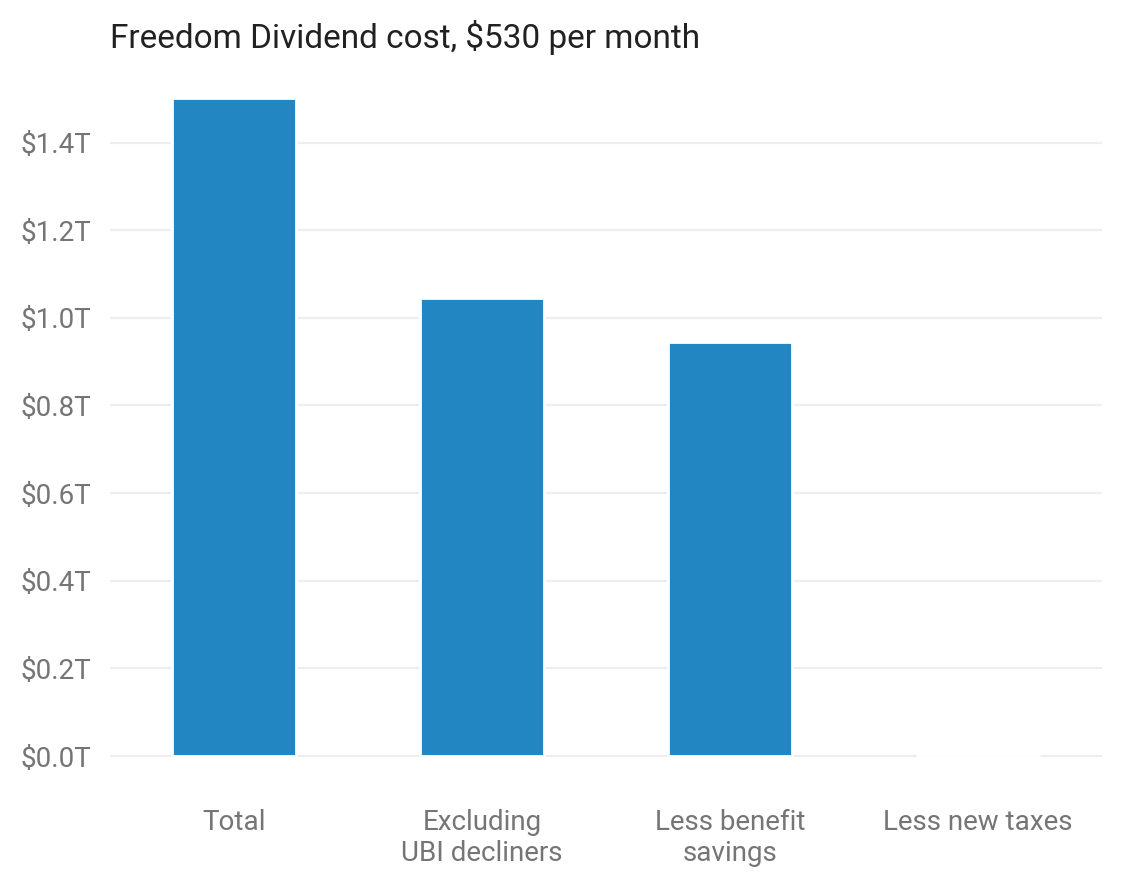

In [31]:
ax = budget_t.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(round(x, 1), ',') + 'T'))
plt.title('Freedom Dividend cost, $530 per month', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

## Analysis

### Benefit reductions

Exploratory.

In [32]:
base.columns

Index(['n21', 'wic_ben', 'n1820', 'snap_ben', 'ssi_ben', 'expanded_income',
       'tanf_ben', 'aftertax_income', 'e02400', 'nu18', 'XTOT', 's006',
       'e02300', 'n65', 's006_m', 'aftertax_income_m', 'XTOT_m',
       'expanded_income_m', 'aftertax_income_percentile_exact',
       'aftertax_income_percentile', 'aftertax_income_2percentile',
       'aftertax_income_ventile', 'aftertax_income_decile',
       'aftertax_income_quintile', 'aftertax_income_quartile',
       'expanded_income_percentile_exact', 'expanded_income_percentile',
       'expanded_income_2percentile', 'expanded_income_ventile',
       'expanded_income_decile', 'expanded_income_quintile',
       'expanded_income_quartile', 'bens', 'adults', 'adult_citizens',
       'ubi_max', 'ubi', 'bens_yang', 'bens_cut', 'ubi_m', 'ubi_max_m',
       'bens_m', 'bens_yang_m', 'bens_cut_m', 'afti_yang_pre_new_taxes',
       'afti_yang_pre_new_taxes_noneg',
       'afti_yang_pre_new_taxes_noneg_percentile_exact',
       'afti_yang_pr

In [33]:
base[base.e02400 > 0].sample()[['ubi', 'e02400', 'bens_yang', 'adults']]

,ubi,e02400,bens_yang,adults
RECID,,,,
203774,0.0,14739.96,14739.96,1.0


In [34]:
BEN_NAME = {
    'e02400': 'Social Security',
    'e02300': 'Unemployment',
    'snap_ben': 'SNAP',
    'ssi_ben': 'SSI',
    'tanf_ben': 'TANF',
    'housing_ben': 'Housing assistance',
    'wic_ben': 'WIC',
    'other_ben': 'Other'
}

In [35]:
ben_reduction_l = []
for i in BENS:
    tmp = pd.DataFrame({
        'base': [tch.weighted_sum(base, i)],
        'yang': [tch.weighted_sum(base[base.ubi == 0], i)]
    }, index=[i])
    ben_reduction_l.append(tmp)

ben_reduction = pd.concat(ben_reduction_l)
ben_reduction['ben_name'] = ben_reduction.index.map(BEN_NAME)
ben_reduction['reduction'] = ben_reduction.base - ben_reduction.yang
ben_reduction['pct_reduction'] = ben_reduction.reduction / ben_reduction.base
ben_reduction

,base,yang,ben_name,reduction,pct_reduction
snap_ben,9.07e+10,5.28e+10,SNAP,3.79e+10,0.42
ssi_ben,5.53e+10,4.97e+10,SSI,5.61e+09,0.10
tanf_ben,3.05e+10,2.28e+10,TANF,7.76e+09,0.25
wic_ben,3.79e+09,1.19e+09,WIC,2.59e+09,0.68
e02400,1.20e+12,1.18e+12,Social Security,2.73e+10,0.02
e02300,3.04e+10,1.16e+10,Unemployment,1.88e+10,0.62


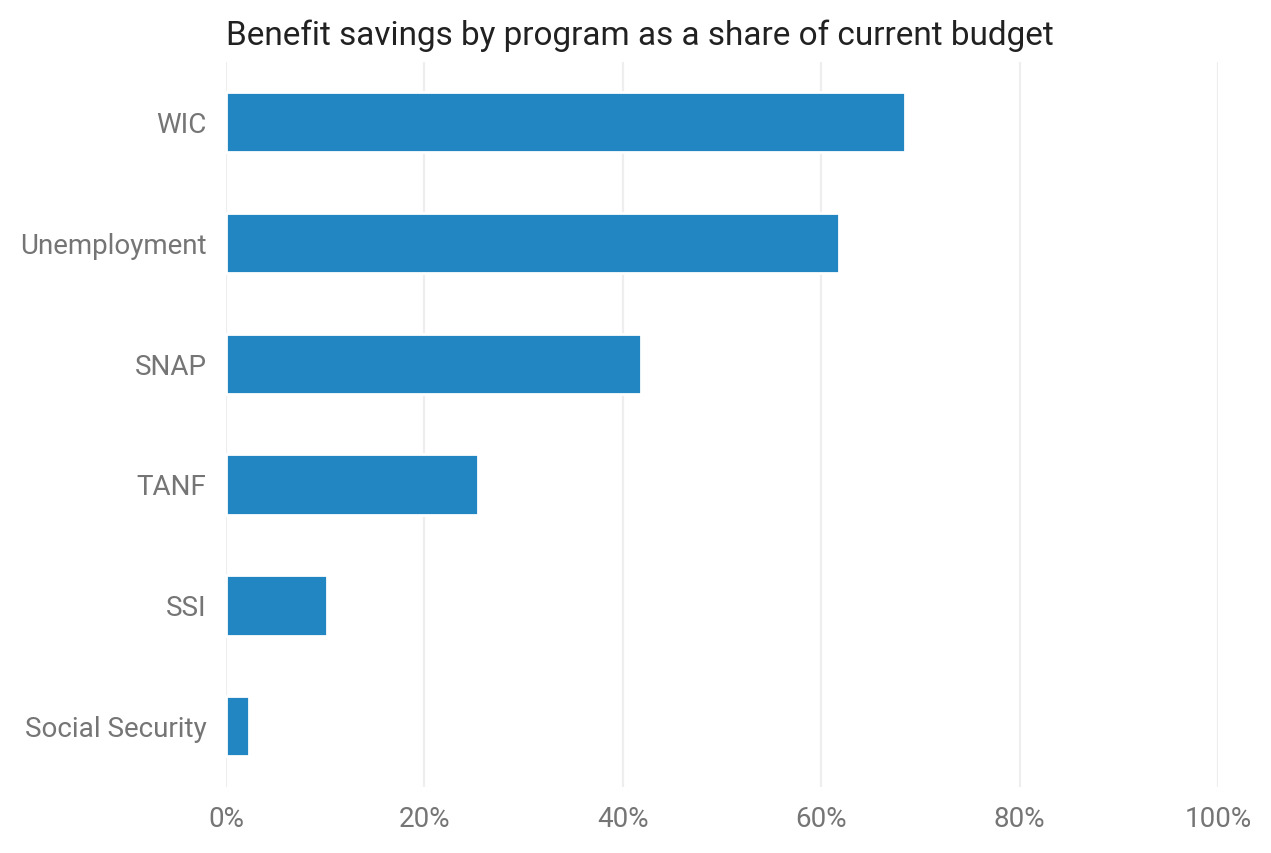

In [36]:
ax = ben_reduction.sort_values('pct_reduction').plot.barh(x='ben_name', y='pct_reduction', color='#2286c3')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Benefit savings by program as a share of current budget', loc='left')
ax.grid(color=GRID_COLOR, axis='x')
ax.legend_.remove()
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

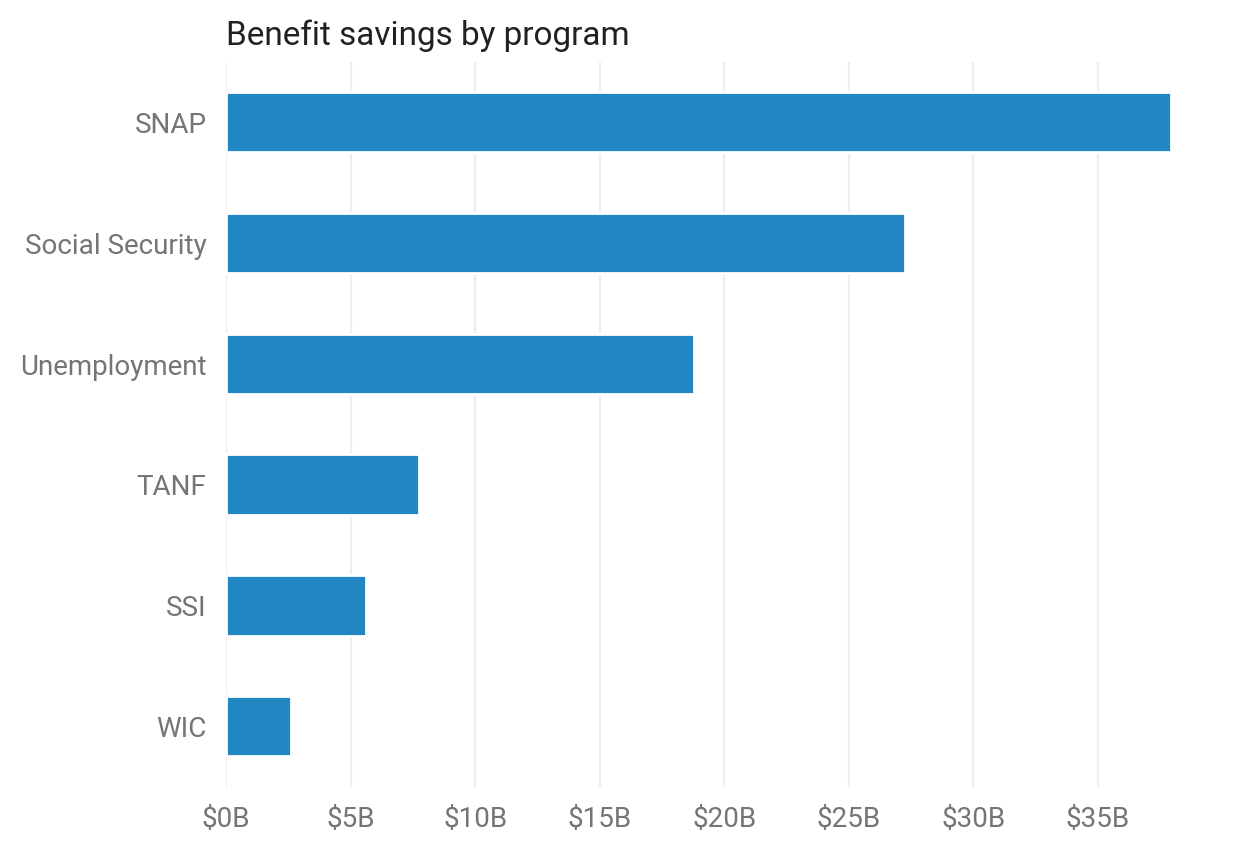

In [37]:
ax = ben_reduction.sort_values('reduction').plot.barh(x='ben_name', y='reduction', color='#2286c3')
# plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x / 1e9), ',') + 'B'))
plt.title('Benefit savings by program', loc='left')
ax.grid(color=GRID_COLOR, axis='x')
ax.legend_.remove()
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

In [38]:
base.sort_values('afti_chg', ascending=False).head()

,n21,wic_ben,n1820,snap_ben,ssi_ben,expanded_income,tanf_ben,aftertax_income,e02400,nu18,...,vat,ftt,new_taxes,vat_m,ftt_m,new_taxes_m,afti_yang_pre_new_taxes_noneg_m,afti_yang,afti_chg,afti_chg_m
RECID,,,,,,,,,,,,,,,,,,,,,
167613,11.0,0.0,1.0,0.0,0.0,3658.27,0.0,3138.33,0.0,0.0,...,4716.84,204.17,6088.56,4.24,1.83e-01,5.47,71.36,73369.77,70231.44,63.08
388397,6.0,0.0,1.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,2642.82,57.20,3245.16,1.49,3.23e-02,1.83,25.11,41274.84,41274.84,23.28
201244,7.0,0.0,0.0,0.0,0.0,27913.62,0.0,24067.54,0.0,0.0,...,4030.36,87.23,5059.79,0.44,9.57e-03,0.56,7.45,62834.26,38766.73,4.25
201242,7.0,0.0,0.0,0.0,0.0,27913.62,0.0,24067.54,0.0,0.0,...,4030.36,87.23,5059.79,0.44,9.57e-03,0.56,7.45,62834.26,38766.73,4.25
201252,7.0,0.0,0.0,0.0,0.0,27913.62,0.0,24067.54,0.0,0.0,...,4030.36,87.23,5059.79,0.44,9.57e-03,0.56,7.45,62834.26,38766.73,4.25


In [39]:
base.vat_m.sum() / base.afti_yang_pre_new_taxes_noneg_m.sum()

0.054687098728959195

## Changes per household

### Average changes by decile

In [ ]:
def 

In [40]:
decile = base.groupby('expanded_income_decile')['aftertax_income_m', 'afti_chg_m',
                                                'new_taxes_m', 'afti_yang_pre_new_taxes_noneg_m', 's006'].sum()
decile['afti_chg'] = 1e6 * decile.afti_chg_m / decile.s006
decile['afti_chg_pct'] = decile.afti_chg_m / decile.aftertax_income_m
decile['new_taxes'] = 1e6 * decile.new_taxes_m / decile.s006
decile['new_taxes_pct'] = decile.new_taxes_m / decile.afti_yang_pre_new_taxes_noneg_m
decile.drop(0, inplace=True)
decile

,aftertax_income_m,afti_chg_m,new_taxes_m,afti_yang_pre_new_taxes_noneg_m,s006,afti_chg,afti_chg_pct,new_taxes,new_taxes_pct
expanded_income_decile,,,,,,,,,
1,3.65e+05,92224.39,36207.61,4.93e+05,2.47e+07,3734.59,2.53e-01,1466.21,0.07
2,7.24e+05,37146.45,60380.07,8.22e+05,2.32e+07,1603.61,5.13e-02,2606.61,0.07
3,8.55e+05,25586.66,69220.56,9.49e+05,2.06e+07,1243.87,2.99e-02,3365.09,0.07
4,9.42e+05,13609.75,76167.07,1.03e+06,1.79e+07,759.63,1.45e-02,4251.27,0.07
5,1.04e+06,-1783.76,83721.41,1.12e+06,1.61e+07,-111.10,-1.72e-03,5214.65,0.07
6,1.13e+06,-8773.95,92101.08,1.22e+06,1.46e+07,-600.75,-7.74e-03,6306.14,0.08
7,1.28e+06,-17129.81,101472.51,1.37e+06,1.37e+07,-1246.10,-1.33e-02,7381.57,0.07
8,1.52e+06,-30739.10,117494.79,1.60e+06,1.32e+07,-2325.70,-2.03e-02,8889.56,0.07
9,1.94e+06,-53423.77,147969.22,2.04e+06,1.30e+07,-4116.24,-2.75e-02,11400.86,0.07


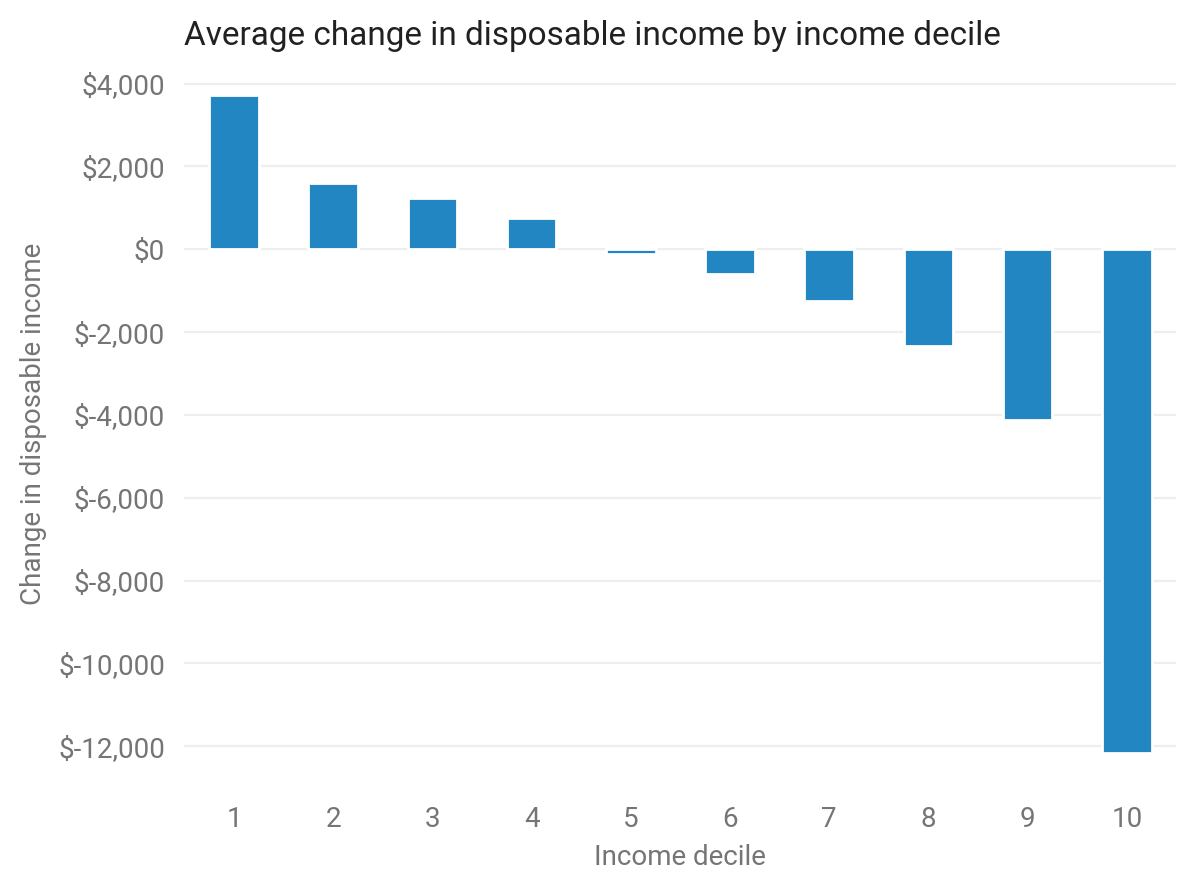

In [41]:
ax = decile.afti_chg.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average change in disposable income by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change in disposable income')
plt.xlabel('Income decile')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

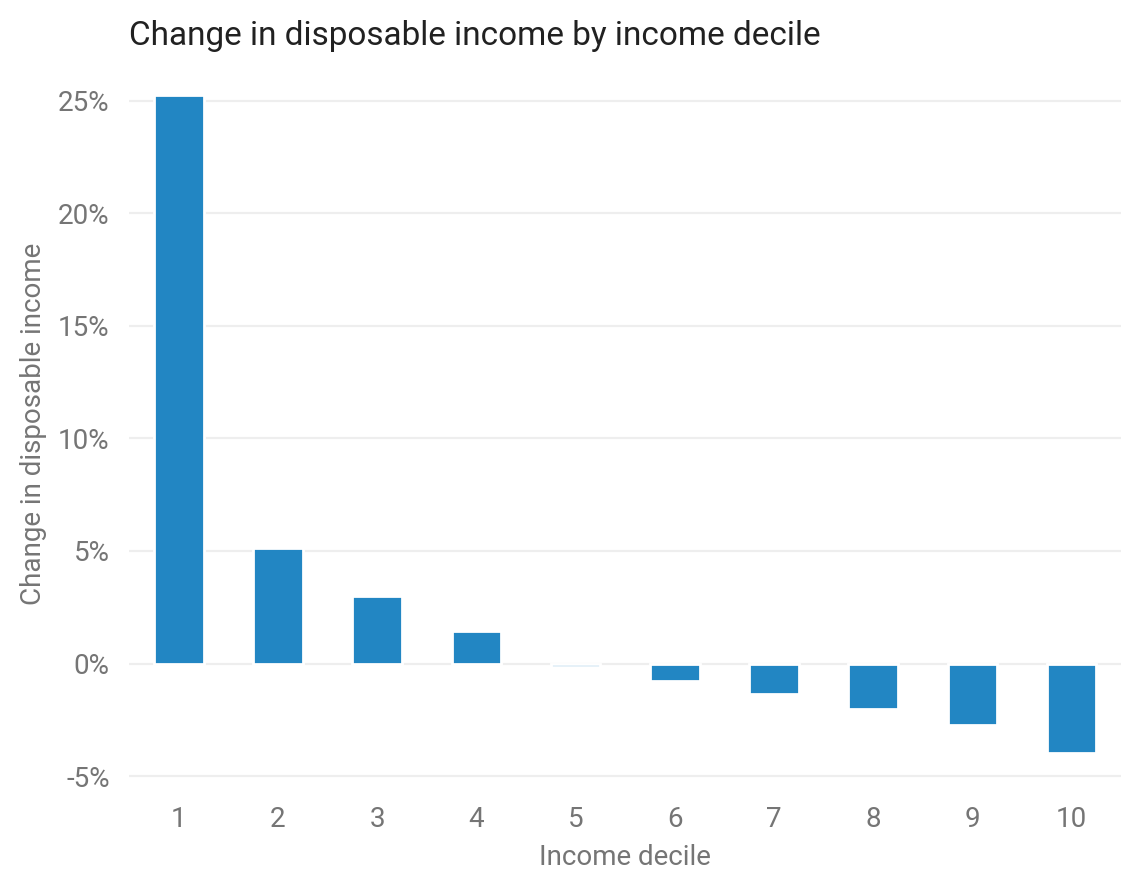

In [42]:
ax = decile.afti_chg_pct.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.xticks(rotation=0)
plt.title('Change in disposable income by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Change in disposable income')
plt.xlabel('Income decile')
sns.despine(left=True, bottom=True)
plt.show()

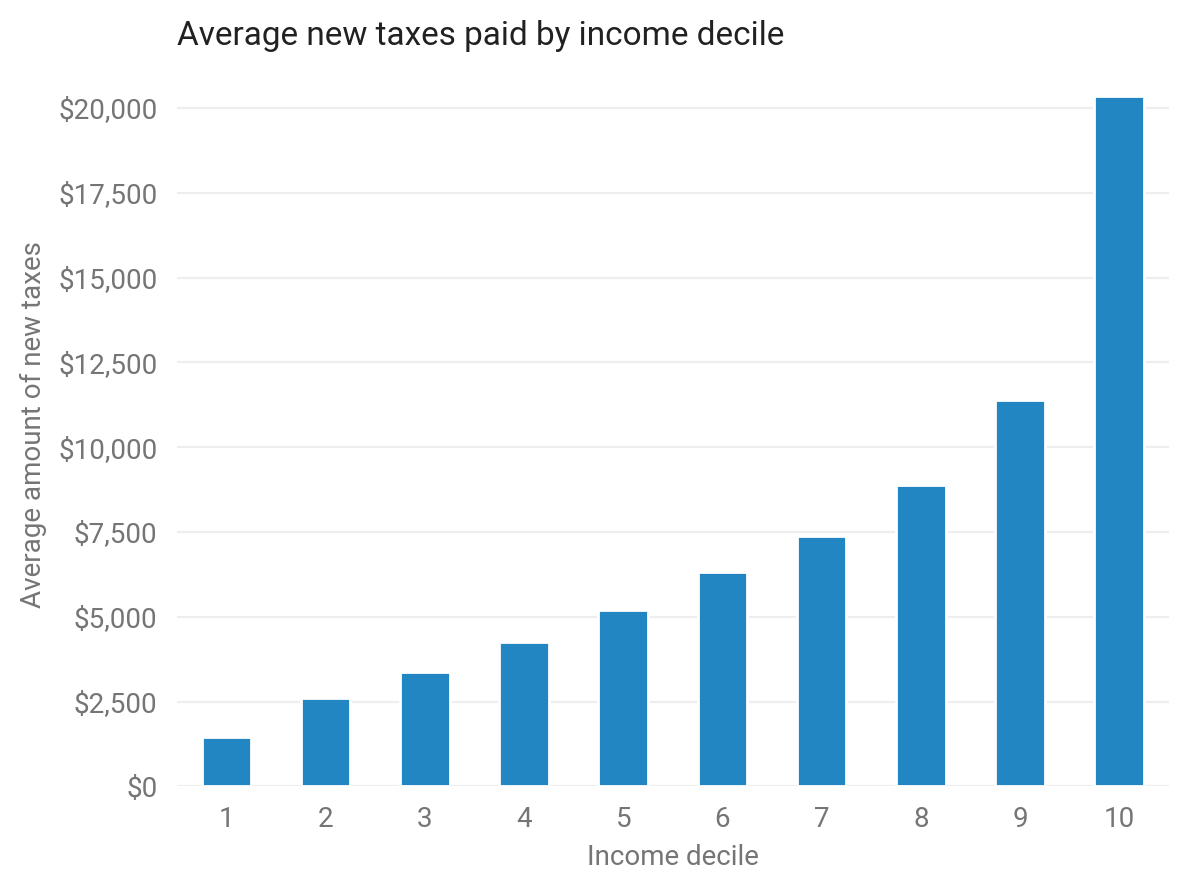

In [43]:
ax = decile.new_taxes.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average new taxes paid by income decile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('Average amount of new taxes')
plt.xlabel('Income decile')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

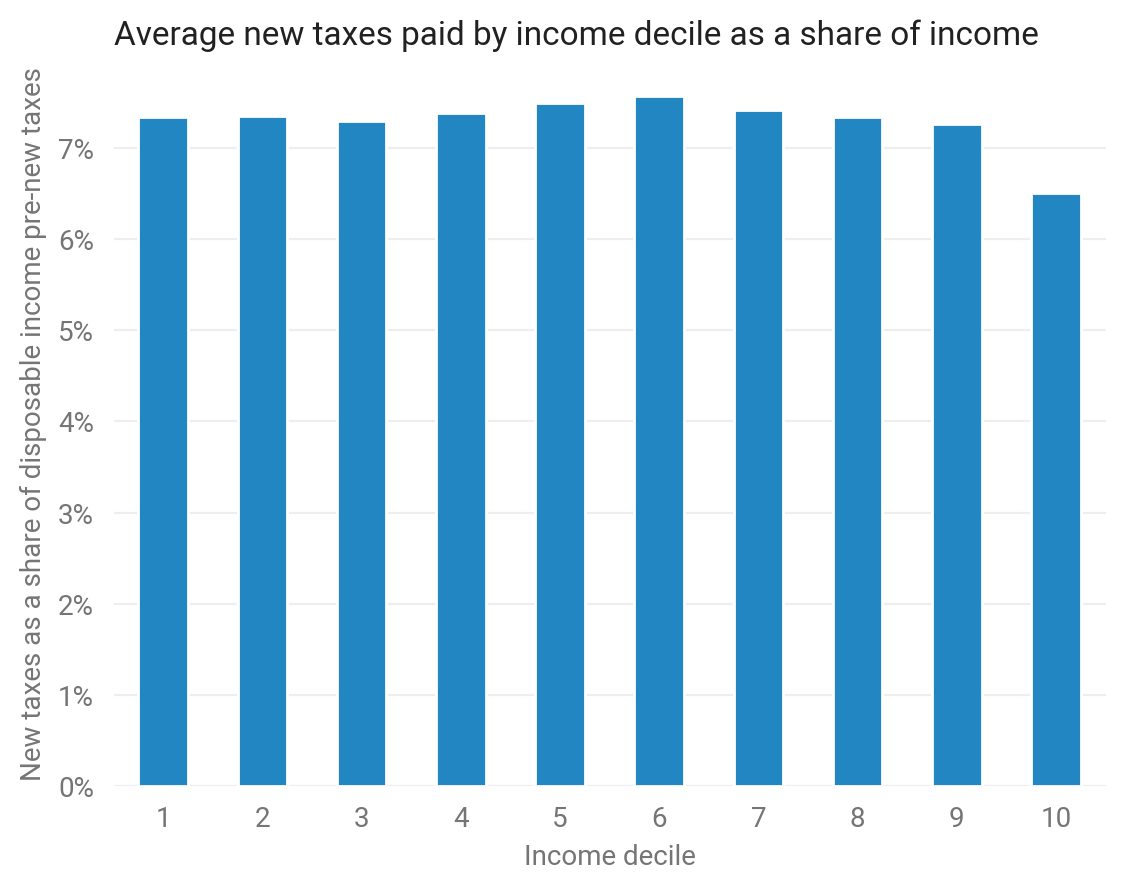

In [44]:
ax = decile.new_taxes_pct.plot.bar(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Average new taxes paid by income decile as a share of income', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.ylabel('New taxes as a share of disposable income pre-new taxes')
plt.xlabel('Income decile')
sns.despine(left=True, bottom=True)
plt.xticks(rotation=0)
plt.show()

### Averages by ventile

In [45]:
ventile = base.groupby('expanded_income_ventile')['aftertax_income_m', 'afti_chg_m', 's006'].sum()
ventile['afti_chg'] = 1e6 * ventile.afti_chg_m / ventile.s006
ventile['afti_chg_pct'] = ventile.afti_chg_m / ventile.aftertax_income_m
ventile.drop(0, inplace=True)
ventile

,aftertax_income_m,afti_chg_m,s006,afti_chg,afti_chg_pct
expanded_income_ventile,,,,,
5,1.08e+05,54488.98,1.28e+07,4270.00,5.07e-01
10,2.57e+05,37735.42,1.19e+07,3162.08,1.47e-01
15,3.35e+05,21780.98,1.17e+07,1854.56,6.50e-02
20,3.89e+05,15365.47,1.14e+07,1345.52,3.95e-02
25,4.21e+05,13925.89,1.08e+07,1290.78,3.31e-02
30,4.34e+05,11660.77,9.78e+06,1192.13,2.69e-02
35,4.63e+05,8772.71,9.31e+06,942.71,1.89e-02
40,4.78e+05,4837.04,8.61e+06,561.76,1.01e-02
45,5.06e+05,1032.18,8.25e+06,125.17,2.04e-03


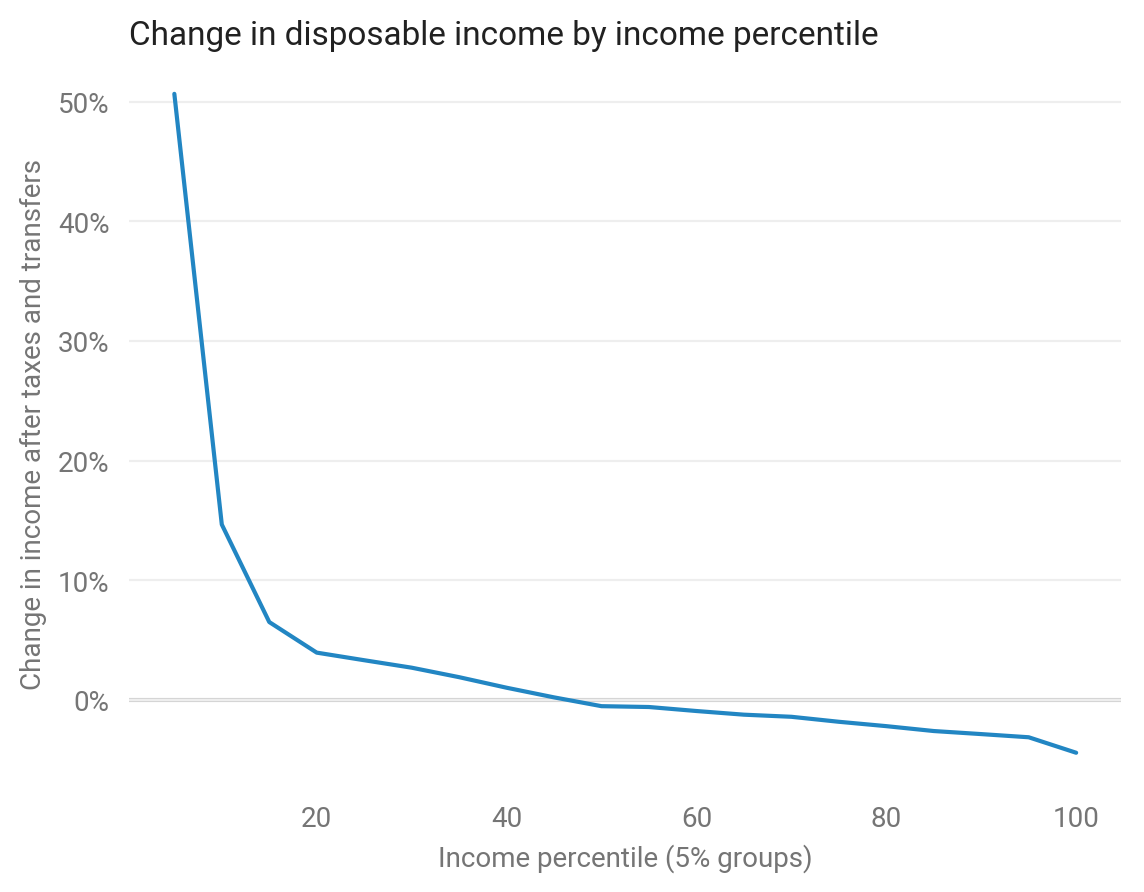

In [46]:
ax = ventile.afti_chg_pct.plot(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '{:.0%}'.format(x)))
plt.title('Change in disposable income by income percentile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.xlabel('Income percentile (5% groups)')
plt.ylabel('Change in income after taxes and transfers')
sns.despine(left=True, bottom=True)
ax.axhline(0, color='lightgray', zorder=-1)
plt.show()

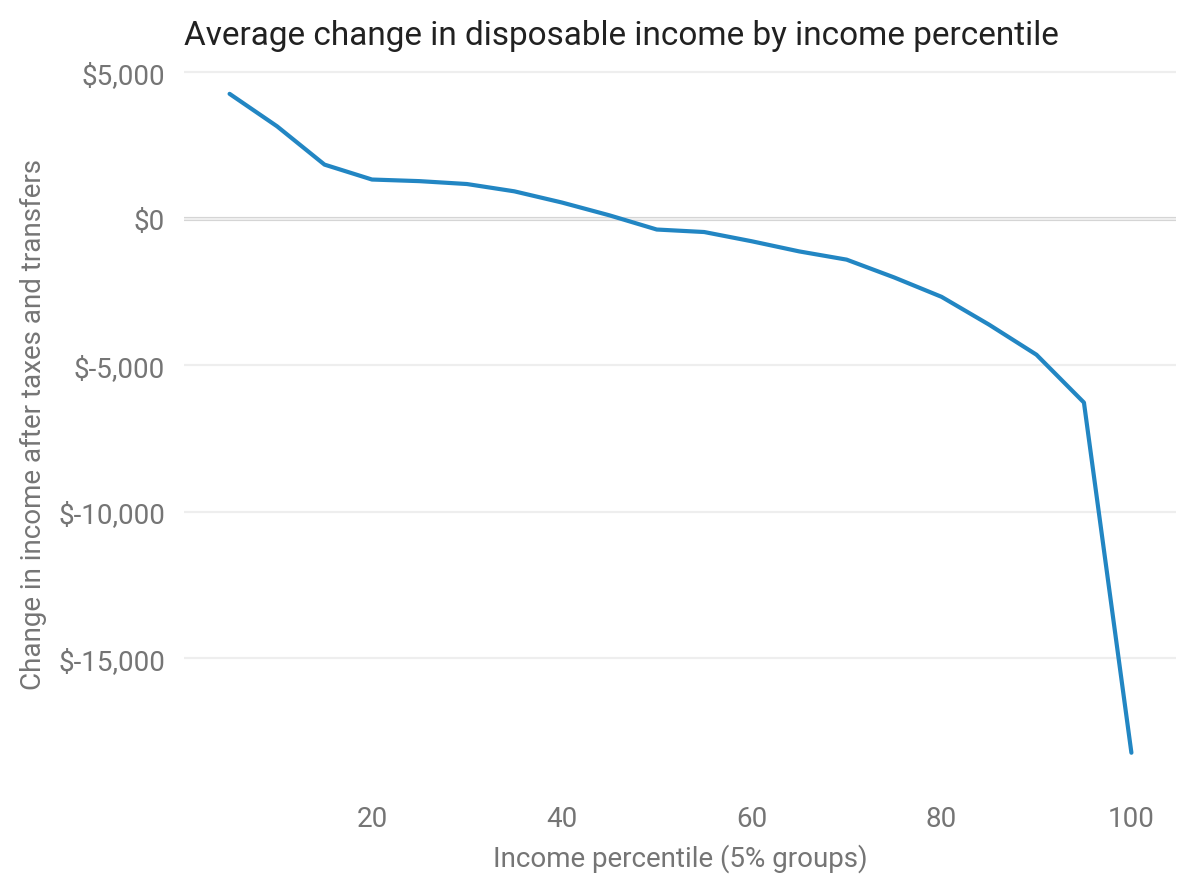

In [47]:
ax = ventile.afti_chg.plot(color='#2286c3')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
    lambda x, _: '$' + format(int(x), ',')))
plt.title('Average change in disposable income by income percentile', loc='left')
ax.grid(color=GRID_COLOR, axis='y')
plt.xlabel('Income percentile (5% groups)')
plt.ylabel('Change in income after taxes and transfers')
sns.despine(left=True, bottom=True)
ax.axhline(0, color='lightgray', zorder=-1)
plt.show()

### DIstribution of household-level changes

In [139]:
base['aftertax_income_noneg'] = np.maximum(base.aftertax_income, 0)

In [151]:
base['di_pctchg'] = base.afti_chg / base.aftertax_income_noneg

In [152]:
base['winner'] = base.di_pctchg > 0

In [154]:
(base.groupby('winner').XTOT_m.sum() / base.XTOT_m.sum())

winner
False    0.47
True     0.53
Name: XTOT_m, dtype: float64

In [155]:
(base.groupby('winner').s006.sum() / base.s006.sum())

winner
False    0.49
True     0.51
Name: s006, dtype: float64

In [156]:
base['ei_bin'] = (
    pd.cut(base.expanded_income.astype('int'),
           pd.Series([0, 10, 20, 30, 40, 50, 75, 100, 200, 500, 1000, np.inf])
           * 1000,
           labels=['Less than \$10K', '\$10K to \$20K', '\$20K to \$30K', 
                   '\$30K to \$40K', '\$40K to \$50K', '\$50K to \$75K', 
                   '\$75K to \$100K', '\$100K to \$200K', '\$200K to \$500K', 
                   '\$500K to \$1M', '\$1M or more']))

In [157]:
base['di_pctchg_bin'] = pd.cut(
    base.di_pctchg,
    [-np.inf, -0.05, -0.01, 0.01, 0.05, np.inf],
    labels=['Decrease greater than 5%', 'Decrease 1% to 5%',
            'Less than 1% change',
            'Increase 1% to 5%', 'Increase greater than 5%'])

In [158]:
base.groupby('di_pctchg_bin').di_pctchg.min()

di_pctchg_bin
Decrease greater than 5%   -7.66e-02
Decrease 1% to 5%          -5.00e-02
Less than 1% change        -1.00e-02
Increase 1% to 5%           1.00e-02
Increase greater than 5%    5.00e-02
Name: di_pctchg, dtype: float64

In [159]:
base.sort_values('di_pctchg')[['aftertax_income', 'afti_yang', 'di_pctchg', 'di_pctchg_bin']].head()

,aftertax_income,afti_yang,di_pctchg,di_pctchg_bin
RECID,,,,
300796,78302.74,72302.72,-0.08,Decrease greater than 5%
64137,81572.04,75321.51,-0.08,Decrease greater than 5%
290375,78587.38,72565.55,-0.08,Decrease greater than 5%
197586,77054.19,71149.84,-0.08,Decrease greater than 5%
154581,83917.12,77486.89,-0.08,Decrease greater than 5%


In [161]:
base[base.aftertax_income > 0].sort_values('di_pctchg')[['aftertax_income', 'afti_yang', 'di_pctchg', 'di_pctchg_bin']].head()

,aftertax_income,afti_yang,di_pctchg,di_pctchg_bin
RECID,,,,
300796,78302.74,72302.72,-0.08,Decrease greater than 5%
64137,81572.04,75321.51,-0.08,Decrease greater than 5%
154581,83917.12,77486.89,-0.08,Decrease greater than 5%
193047,80916.45,74716.15,-0.08,Decrease greater than 5%
290375,78587.38,72565.55,-0.08,Decrease greater than 5%


In [162]:
base[base.di_pctchg > -100000].di_pctchg.min()

-0.07662586413705254

In [163]:
def combined_pivot(group_bin, chg_bin, weight, exclude_negs=True):
    if exclude_negs:
        df = base[(base.afti_yang > 0) & (base.aftertax_income > 0) &
                  (base.expanded_income > 0)]
    else:
        df = base
    pivot = df.pivot_table(index=group_bin, columns=chg_bin, 
                           values=weight, aggfunc=sum, fill_value=0)
    pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)
    pivot_total = df.pivot_table(columns=chg_bin, 
                                 values=weight, aggfunc=sum, fill_value=0)
    pivot_total_pct = pivot_total.div(pivot_total.sum(axis=1), axis=0)
    pivot_total_pct.index = ['Total']
    # Create empty row to distinguish total row.
#     pivot_empty = pd.Series(name='')
    pivot_empty = pivot_total_pct.copy()
    pivot_empty.loc[:] = None
    pivot_empty.index = ['']
    # Can't concat in the correct order:
    # TypeError: cannot append a non-category item to a CategoricalIndex
    # Instead reorder in a separate step.
    pivot_combined_pct = pd.concat([pivot_total_pct, pivot_pct, pivot_empty])
    return(pivot_combined_pct.iloc[1:].append(pivot_combined_pct.iloc[0]).iloc[:, ::-1])

In [164]:
COLORS = ['#004ba0',  # Dark blue.
          '#63a4ff',  # Light blue.
          '#e0e0e0',  # Gray.
          '#ffc046',  # Light amber.
          '#c56000']  # Medium amber.

In [165]:
def dist_plot(income_bin, chg_bin, weight):
    ax = combined_pivot(income_bin, chg_bin, weight).plot.barh(
        stacked=True, color=COLORS, width=0.97, figsize=(11, 8))
    legend = plt.legend(bbox_to_anchor=(-0.005, 1.0, 0.96, .102), loc=3,
                        ncol=5, mode='expand', borderaxespad=0., frameon=False)
    plt.setp(plt.gca().get_legend().get_texts(), fontsize=7.5)
    sns.despine(left=True, bottom=True)
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
    ax.set(xlabel='', 
           ylabel='Household income')
    plt.title('Distribution of ' +
              ('tax returns' if weight == 's006' else 'people') + ' by ' +
              ('size of tax change' if chg_bin == 'tax_chg_bin'
               else 'effect on disposable income'),
              loc='left', y=1.05, fontsize=16)
    return ax

In [166]:
combined_pivot('ei_bin', 'di_pctchg_bin', 's006')

di_pctchg_bin,Increase greater than 5%,Increase 1% to 5%,Less than 1% change,Decrease 1% to 5%,Decrease greater than 5%
Less than \$10K,7.80e-01,3.50e-03,1.73e-03,3.17e-03,0.21
\$10K to \$20K,7.82e-01,1.16e-02,3.86e-03,8.67e-03,0.19
\$20K to \$30K,6.67e-01,3.38e-02,8.63e-03,1.72e-02,0.27
\$30K to \$40K,4.95e-01,4.42e-02,1.28e-02,1.74e-02,0.43
\$40K to \$50K,5.12e-01,3.99e-02,1.93e-02,2.67e-02,0.40
\$50K to \$75K,3.42e-01,2.02e-01,2.15e-02,3.60e-02,0.40
\$75K to \$100K,2.55e-01,1.88e-01,1.00e-01,3.57e-02,0.42
\$100K to \$200K,1.27e-01,2.23e-01,1.29e-01,1.11e-01,0.41
\$200K to \$500K,6.43e-03,4.50e-02,2.63e-01,3.35e-01,0.35
\$500K to \$1M,0.00e+00,3.21e-04,6.08e-03,5.52e-01,0.44


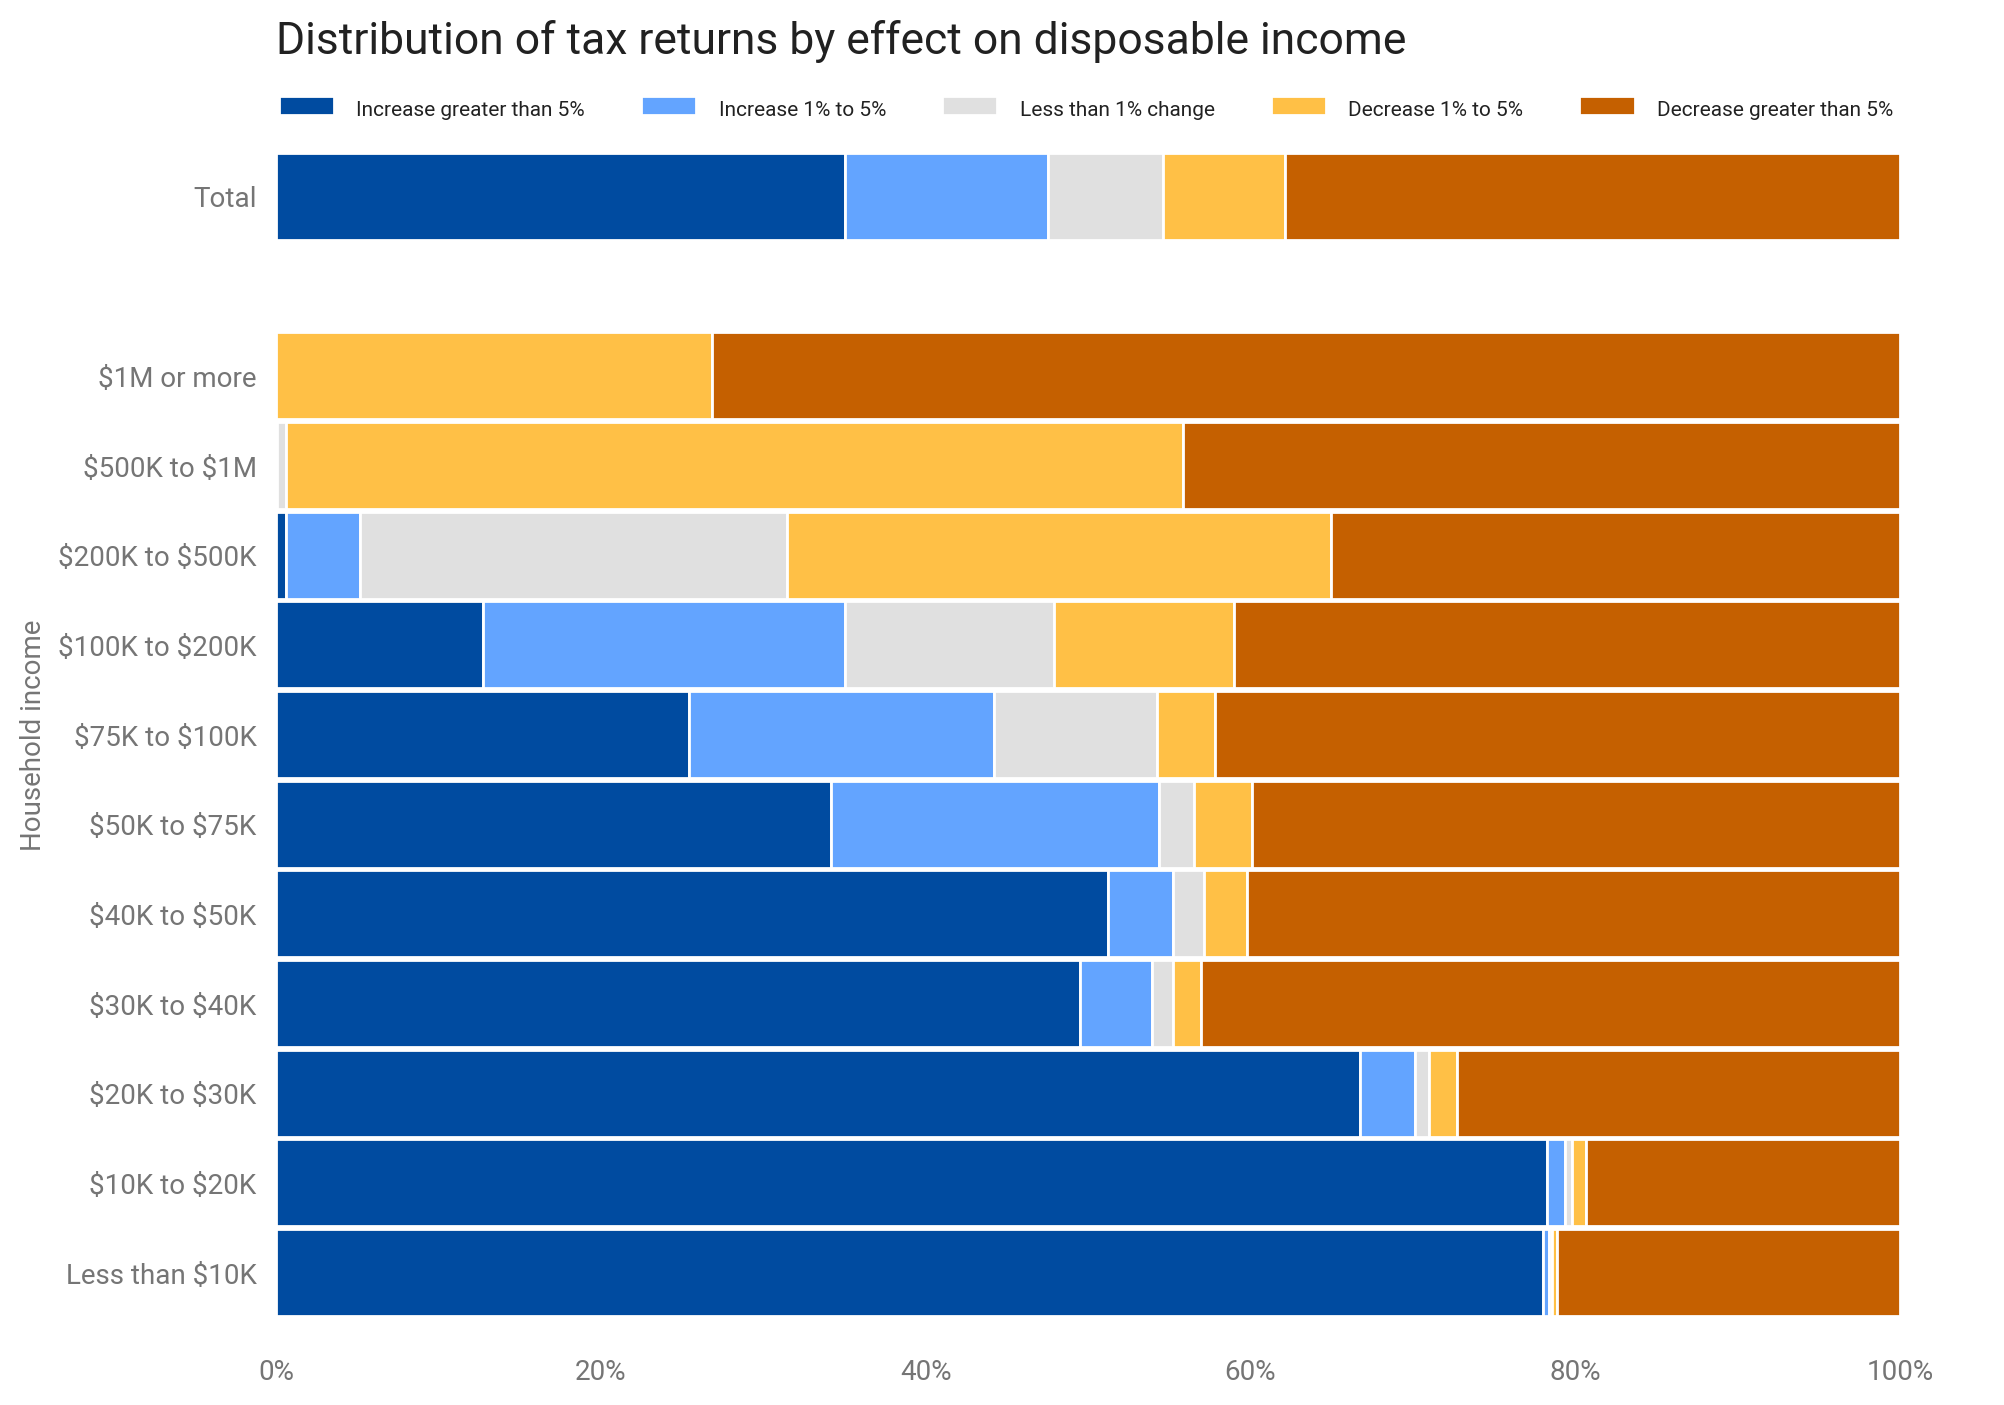

In [167]:
ax = dist_plot('ei_bin', 'di_pctchg_bin', 's006')

In [168]:
combined_pivot('ei_bin', 'di_pctchg_bin', 'XTOT_m')

di_pctchg_bin,Increase greater than 5%,Increase 1% to 5%,Less than 1% change,Decrease 1% to 5%,Decrease greater than 5%
Less than \$10K,0.80,3.58e-03,1.49e-03,2.86e-03,0.19
\$10K to \$20K,0.80,1.07e-02,4.01e-03,8.99e-03,0.18
\$20K to \$30K,0.70,3.14e-02,9.15e-03,1.87e-02,0.24
\$30K to \$40K,0.56,4.27e-02,1.39e-02,2.19e-02,0.36
\$40K to \$50K,0.56,4.73e-02,2.04e-02,3.33e-02,0.34
\$50K to \$75K,0.40,1.70e-01,2.68e-02,4.39e-02,0.36
\$75K to \$100K,0.36,1.26e-01,8.23e-02,4.58e-02,0.38
\$100K to \$200K,0.17,2.85e-01,1.07e-01,8.22e-02,0.36
\$200K to \$500K,0.01,6.52e-02,3.02e-01,3.28e-01,0.29
\$500K to \$1M,0.00,7.21e-04,1.17e-02,6.38e-01,0.35


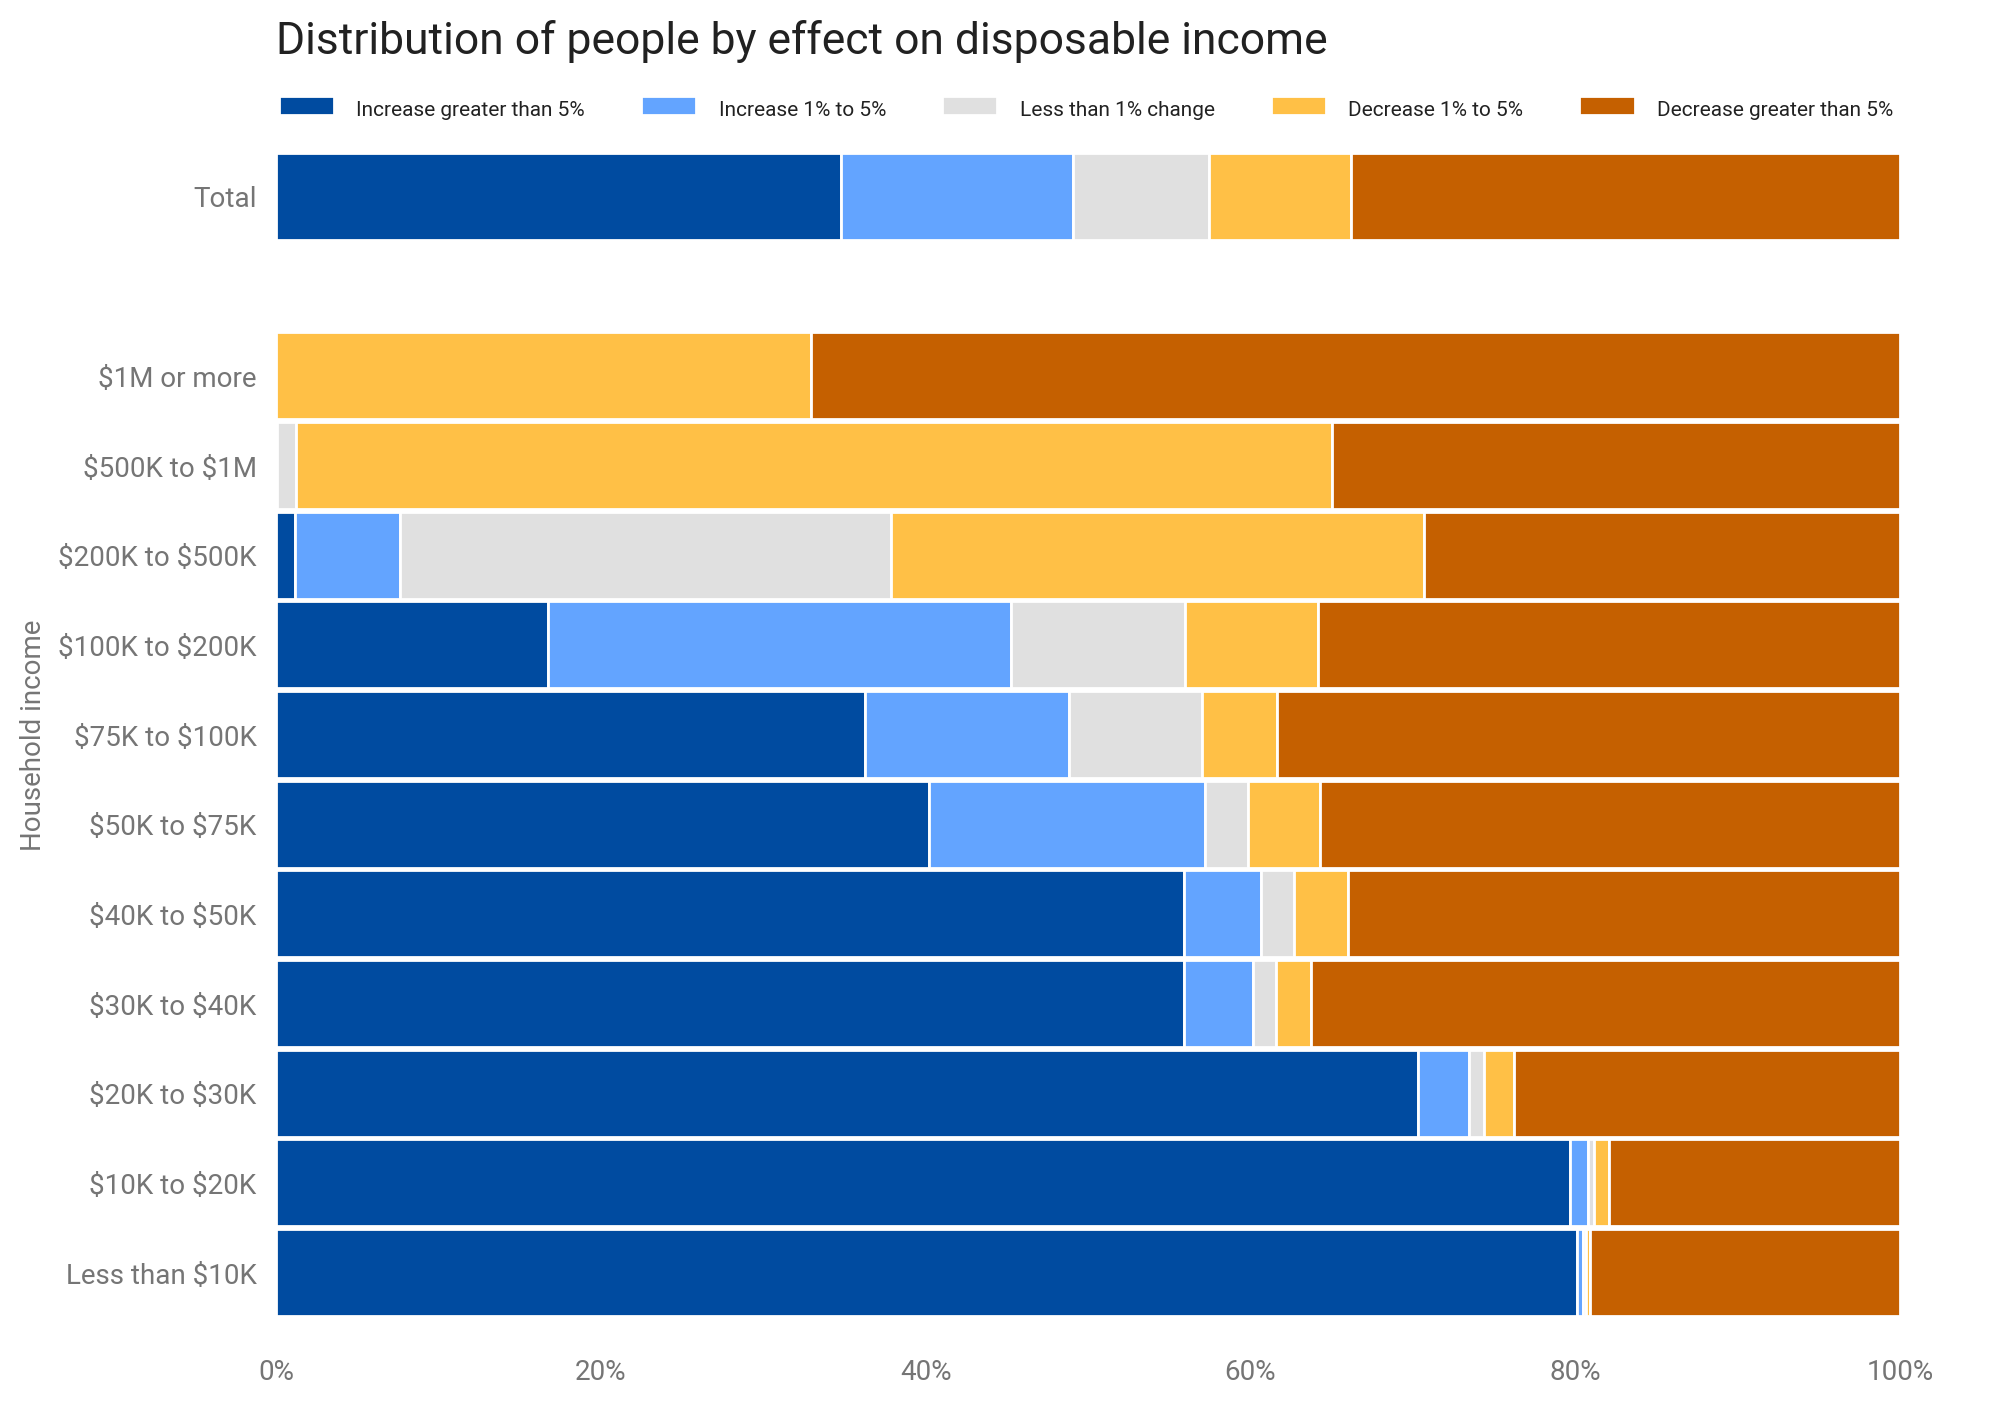

In [169]:
ax = dist_plot('ei_bin', 'di_pctchg_bin', 'XTOT_m')

## Changes to the disposable income distribution

### Poverty

In [61]:
base['fpl'] = tch.fpl(base.XTOT)
base['fpl_market_m'] = base.XTOT_m * (base.expanded_income < base.fpl)
base['fpl_base_m'] = base.XTOT_m * (base.aftertax_income < base.fpl)
base['fpl_yang_m'] = base.XTOT_m * (base.afti_yang < base.fpl)

In [62]:
base.fpl_base_m.sum() / base.XTOT_m.sum()

0.04506700018006928

In [63]:
base.fpl_yang_m.sum() / base.XTOT_m.sum()

0.03057362128497383

In [64]:
base[base.fpl_base_m < base.fpl_yang_m].adults.describe()

count    407.00
mean       0.95
std        0.80
min        0.00
25%        0.00
50%        1.00
75%        1.00
max        4.00
Name: adults, dtype: float64

### Inequality

#### Gini

In [65]:
tch.gini(base.expanded_income, base.s006)

0.4840889750635081

In [66]:
tch.gini(base.aftertax_income, base.s006)

0.4529853146121265

In [67]:
tch.gini(base.afti_yang, base.s006)

0.4315369319022771

#### Top 1% share

In [68]:
tch.add_weighted_quantiles(base, 'afti_yang')

In [69]:
def top_1pct(df, col):
    return(tch.weighted_sum(df[df[col + '_percentile'] == 100], col) /
           tch.weighted_sum(df, col))

In [70]:
top_1pct(base, 'afti_yang')

0.0910886751028544

### Change in deciles

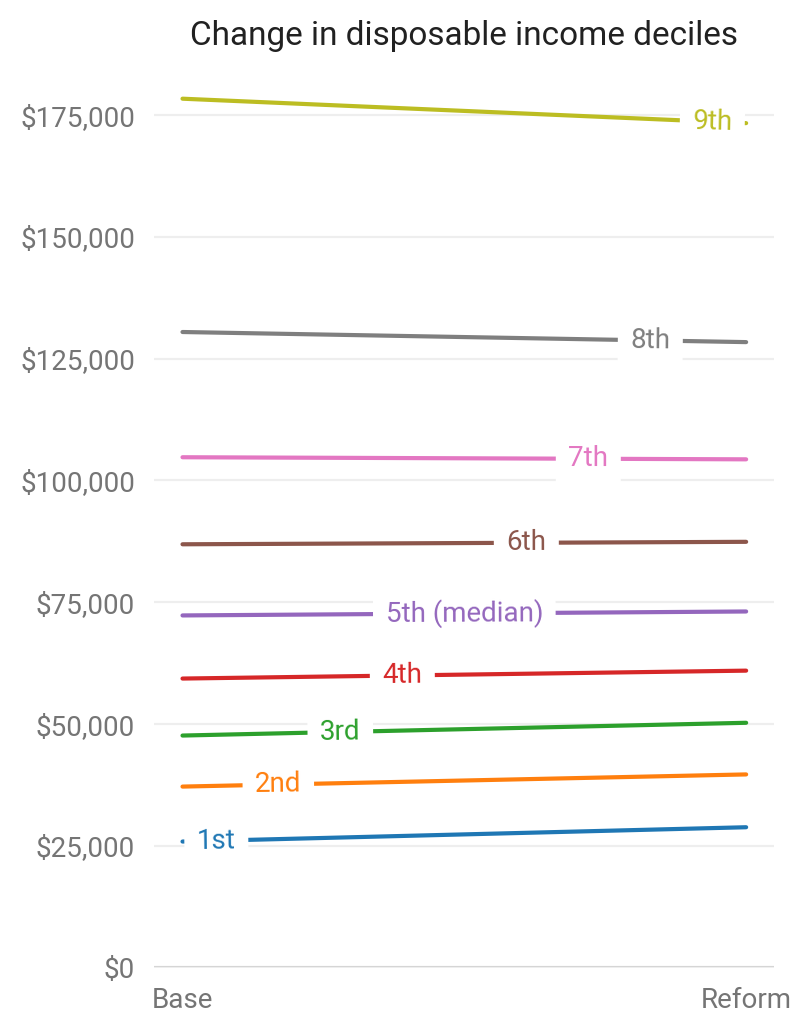

In [71]:
ax = tch.quantile_chg_plot(base.aftertax_income, base.afti_yang, base.XTOT_m, base.XTOT_m)

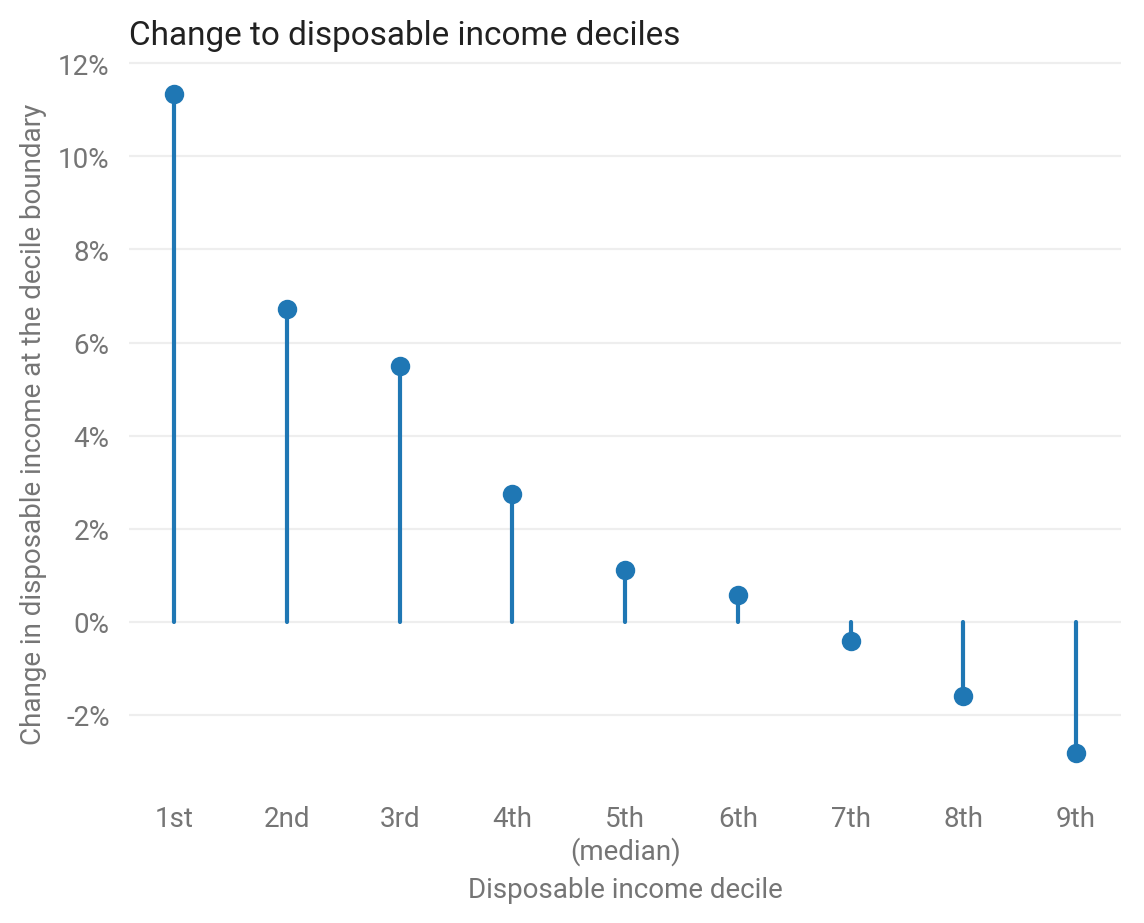

In [72]:
ax = tch.quantile_pct_chg_plot(base.aftertax_income, base.afti_yang, base.XTOT_m, base.XTOT_m)